## Super-resolve output

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.backends.cudnn as cudnn
from PIL import Image

from torchvision.transforms import ToTensor
#from skimage.metrics import peak_signal_noise_ratio as psnr
#from skimage.metrics import structural_similarity as ssim

from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

import numpy as np
import matplotlib.pyplot as plt
from dataset.data_loader_RGB import totensor
import torchvision.utils as utils

In [6]:
# Path to data

#low_res_img_path = '../dataset/300W-3D-crap-56/test/AFW_37096733_1.jpg'
#original_img_path = '../dataset/300W-3D-low-res-22/test/AFW_37096733_1.jpg'

#low_res_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-crap-56/test/AFW_37096733_1.jpg'
#original_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-low-res-224/test/AFW_37096733_1.jpg'

low_res_img_path = '/home/jupyter/dataset/LR_56/test/018001.jpg'
original_img_path = '/home/jupyter/dataset/HR/test/018001.jpg'

#low_res_img_path = '/media/angelo/DATEN/Datasets/CelebA/LR_56/test/018001.jpg'
#original_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018001.jpg'


model_path = 'models/SRGAN_FaceLoss_x4_epoch_11.pth'

In [7]:
# Input Image Setting

GPU_IN_USE = torch.cuda.is_available()

if GPU_IN_USE:
    cudnn.benchmark = True

# For SRCNN and VDSR
#img = Image.open(low_res_img_path).resize((224,224), Image.BICUBIC)

#For SubPixelCNN
#img = Image.open(low_res_img_path).convert('YCbCr')

#y, cb, cr = img.split()
img = Image.open(low_res_img_path)

In [8]:
# Input image setting

device = torch.device('cuda' if GPU_IN_USE else 'cpu')
model = torch.load(model_path, map_location=lambda storage, loc: storage)
model = model.to(device)

data = (ToTensor()(img)).view(1, 3, img.size[1], img.size[0])
#data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
#data = (ToTensor()(img)).view(1, 3, img.size[1], img.size[0])
data = data.to(device)

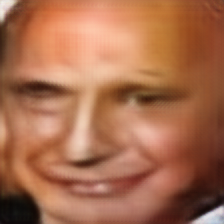

In [9]:
# Output and save image

out = model(data)
out = out.cpu()
out = out.data[0].numpy()
#out = (out * 0.5) + 0.5
out *= 255.0
out = out.transpose((1,2,0))
out_img = np.uint8(out.clip(0, 255))
out_img = Image.fromarray(np.uint8(out_img), mode='RGB')
out_img
#out_img = Image.fromarray(np.uint8(out.clip(0, 255)), mode='YCbCr')
#out_img = np.array(out_img.convert('RGB'))
#out_img.save('result.png')

PSNR and SSIM BICUBIC: 24.184 and 0.630
PSNR and SSIM MODEL:   22.747 and 0.654


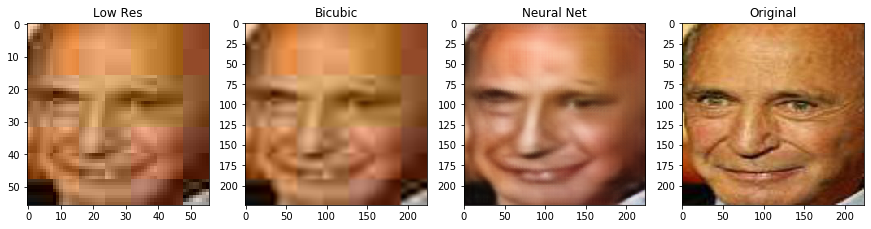

In [10]:
# Checking image quality

out_img = np.array(out_img)
real_img = np.array(Image.open(original_img_path))
bicubic_img = np.array(img.resize((224,224),resample=Image.BICUBIC))

# PSNR and SSIM - Bilinear Interpolation

print('PSNR and SSIM BICUBIC: %.3f and %.3f' %(psnr(bicubic_img, real_img), 
                                               ssim(bicubic_img, real_img, multichannel=True)))
print('PSNR and SSIM MODEL:   %.3f and %.3f' %(psnr(out_img, real_img), 
                                               ssim(out_img, real_img, multichannel=True)))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.gca().set_title('Low Res')
plt.imshow(img)
plt.subplot(1,4,2)
plt.gca().set_title('Bicubic')
plt.imshow(bicubic_img)
plt.subplot(1,4,3)
plt.gca().set_title('Neural Net')
plt.imshow(out_img)
plt.subplot(1,4,4)
plt.gca().set_title('Original')
plt.imshow(real_img)
plt.show()